# Regression Discontinuity Analysis (RDD) in Python
This tutorial explains and applies RDD by reproduction of the results in [Thistlethwait and Campbell,1960](http://dx.doi.org/10.1037/h0044319). For this purpose, we introduce the python package [rdd](https://github.com/evan-magnusson/rdd).

## Scenario
Thistlethwait and Campell studied the causal effect of Certificates of Merrit (CoM) on short and long term career development. In the USA, a CoM is awarded to those students, who score above a certain threshold score. Now, receiving a CoM is obviously confounded by many variable, e.g. socio-economic status of the family, place of residence, etc.. To get an unbiased estimate of the causal effect, the authors developed RDD.
RDD exploits the fact, that students become arbitrarily similar in their characteristic variables, when we reduce the set to those who score close to the threshold score. This is because the influence of counfounding variables becomes dominated by variables s.a. day-dependent performance, sickness, family-tragedy, etc.. In practice, this means we can get an unbiased estimate of the causal effect of CoM on e.g. receving a scholarship through fiting a regression model which allows for a discontinuity at threshold score to the datapoint in vicinity of that threshold score. With their analysis, Thistlethwait and Campell could show, that CoM does effect the chances for receiving a scholarship, but is irrelevant for long-term career plans ([Marinescu2018](https://doi.org/10.1038/s41562-018-0466-5)).
![RDD on CoM example](./src/images/marinescu2018_rdd_inverted.png)[Marinescu2018](https://doi.org/10.1038/s41562-018-0466-5)



## Application
Translating into analysis tools, RDD merely requires us to define a bandwidth of data around a threshold. We then need to truncate our data to this bandwidth. After that, we are ready to fit a regression model of outcome onto the running variable on both sides of the threshold. All three steps are implemented in the rdd python package, which we are going to use for our demonstration below. 
$$
Y_{i} \sim (\alpha_{0} + \beta_0 T_{i}) + (\alpha_{1} + \beta_1 T_{i})\tilde{X_i} + \sum_{k=2}^{K} (\alpha_{k} + \beta_k T_{i}) \phi_{k}(\tilde{X_i}),\:\:\tiny{\begin{aligned}Y&:\text{dependent variable}\\\tilde{X_i} = X_{i} - c&:\text{zero-shifted independent variable}\\c&:\text{treshold value}\\T_{i}\in\{0,1\}&:\text{dummy variable indicating treatment}\end{aligned}}\\
$$
([Keio2016](http://web.mit.edu/teppei/www/teaching/Keio2016/05rd.pdf), [Trochim2006](http://socialresearchmethods.net/kb/statrd.htm))
The model allows for a disconituity at the value of the theshold in all regression coefficients. Since we ensured, that the subjects in our truncated dataset are similar up to random perturbations in all but the running variable, this discontinuity is accountable to the treatment. The coefficient $\beta_0$, thus, quantifies the causal effect of the treatment in an unbiased fashion. If we have a true causal effect of the treatment, we can fit this coefficient with significance.
Just as any other analysis method, RDD come with it own specific set of assumption, that the user needs to be aware of. Firstly, The general setting required the threshold to be of binary nature and the running variable to be continuous. Secondly, if the outcome may be controlled precisely, such that we cannot even expect a random distribution of the data around the threshold, we cannot apply RDD. Further, potential confounder may not have a discontinuity at the threshold value, too. Lastly, there must not be any influence on the threshold value by the subjects generating the data.
([Marinescu2018](https://doi.org/10.1038/s41562-018-0466-5))
### in Neuroscience
Thresholds are ubiquitous in neuroscience, firing thresholds just being the most prominent ones. The following tables was put together by [Marinescu et al.](https://doi.org/10.1038/s41562-018-0466-5), [Landsdell et al.](https://doi.org/10.1101/253351)).

| Area        | Question           | Running variable  | Threshold | Outcome variable | 
| ----------- |:------------------:| -----------------:| --------- | ---------------- |
| Neural data science | What are the neural requirements for movement | Neural drive | Firing threshold | Activity of a downstream neuron or muscle |
| Neural Theory | How much would larger synaptic weight increase reward-seeking behaviour? | Neural drive | Firing Threshold | Behavioural Change |
| Theoretical Neuroscience | What is the causal contribution of a neuron's activity on the reward signal? | Neural drive | Firing Threshold | Reward |

[Landsdell et al.](https://doi.org/10.1101/253351) provide an example in the theoretical neurosciences (see table, row 3). They build a simple model in which neurons can use RDD to estimate the causal effect of their own activity on a reward signal. The model is based on a intergrate-and-fire model. Neural drive, i.e. the leaky integrated input to the neuron, is the running (dependent) variable. Of course, whenever the input exceeds a threshold, the neuron elicits a spike. In response to the spike, the neuron receives a reward signal, e.g. through feed-back neuromodulator signal. Then, the neuron can compare its marginally subthreshold, i.e. sub-spike, neural drive to its marginally supthreshold neural drive. The difference is its estimate of its on contribution to the reward signal. By means of RDD, a neuron can quite easily estimate this contribution even in the presence of correlated inputs. [Landsdell et al.](https://doi.org/10.1101/253351) show that a two-neuron integrate-fire-model with a RDD-based learning rule can successfully estimate causal effects.


## Application
For means of plasticity, we want to reproduce the results by Campbell and Thistlethwait using the original data and an open-source python package.

Load libraries:

In [29]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# RDD
from rdd import rdd

# DATASCIENCE
import numpy as np
import pandas as pd
import statsmodels.api as sm

# PLOTTING
import matplotlib.pyplot as plt
import seaborn as sns


%matplotlib inline

### Load data
We are going to use the Data available on [github repo](https://github.com/jrnold/datums). You can either download it through your browser and copy it to the folder 'causal_neuroscience/data/raw' or in case you have wget installed simply run the command below.

In [30]:
%pwd

'/Users/akshay/Dropbox/Tutorials/causal_neuroscience/notebooks'

In [31]:
!wget -P ../data/raw http://github.com/jrnold/datums/blob/master/data-raw/CampbellThistlewaite1960.csv

URL transformed to HTTPS due to an HSTS policy
--2019-11-05 10:58:38--  https://github.com/jrnold/datums/blob/master/data-raw/CampbellThistlewaite1960.csv
Resolving github.com (github.com)... 140.82.118.4
Connecting to github.com (github.com)|140.82.118.4|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘../data/raw/CampbellThistlewaite1960.csv.1’

CampbellThistlewait     [ <=>                ]  73.96K  --.-KB/s    in 0.1s    

2019-11-05 10:58:39 (633 KB/s) - ‘../data/raw/CampbellThistlewaite1960.csv.1’ saved [75739]



In [32]:
path_2_data = '../data/raw' + '/CampbellThistlewaite1960.csv' # pwd + '/CampbellThistlewaite1960.csv'

In [33]:
path_2_data

'../data/raw/CampbellThistlewaite1960.csv'

In [34]:
data = pd.read_csv(path_2_data)
data
data.info()

,certificate_of_merit,test_score,merit_scholars,number_in_sample,number_respondents,scholarship,scholarship_150,graduate_study,teacher_researcher,intellectualism
0,0,< 1,NaN,419,322,NaN,NaN,NaN,NaN,NaN
1,0,1,NaN,318,256,50.8,41.6,30.6,22.0,3.8
2,0,2,NaN,368,281,58.6,47.0,26.1,18.2,3.6
3,0,3,NaN,320,258,56.7,46.3,29.2,23.8,3.7
4,0,4,NaN,407,338,56.9,45.6,28.0,17.8,3.6
5,0,5,NaN,324,259,55.5,44.9,32.5,18.3,3.9
6,0,6,NaN,333,267,55.3,46.1,28.2,20.1,3.9
7,0,7,NaN,280,213,58.4,44.0,29.6,21.0,3.9
8,0,8,NaN,301,248,56.5,46.8,30.6,17.1,3.8
9,0,9,NaN,256,201,54.9,48.6,32.5,22.9,4.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22 entries, 0 to 21
Data columns (total 10 columns):
certificate_of_merit    22 non-null int64
test_score              22 non-null object
merit_scholars          11 non-null float64
number_in_sample        22 non-null int64
number_respondents      22 non-null int64
scholarship             20 non-null float64
scholarship_150         20 non-null float64
graduate_study          20 non-null float64
teacher_researcher      20 non-null float64
intellectualism         20 non-null float64
dtypes: float64(6), int64(3), object(1)
memory usage: 1.8+ KB


### Data preparation

We are going to use a derivate of the *scholarship* variable as our target (dependent variable) in the regression analysis later on. For unobstructed and clean analysis, we therefore drop the rows containing `NaN` values in the *scholarship* column right away. Further, change the `dtype` of the *test_score* to a numeric type.

In [35]:
data['test_score'].iloc[0] = 0
data['test_score'].iloc[-1] = 21
data['test_score'] = data['test_score'].astype('int64')
data = data.loc[~data['scholarship'].isna()]
# data.head(3)
# data.tail(3)
data
data.info()

,certificate_of_merit,test_score,merit_scholars,number_in_sample,number_respondents,scholarship,scholarship_150,graduate_study,teacher_researcher,intellectualism
1,0,1,NaN,318,256,50.8,41.6,30.6,22.0,3.8
2,0,2,NaN,368,281,58.6,47.0,26.1,18.2,3.6
3,0,3,NaN,320,258,56.7,46.3,29.2,23.8,3.7
4,0,4,NaN,407,338,56.9,45.6,28.0,17.8,3.6
5,0,5,NaN,324,259,55.5,44.9,32.5,18.3,3.9
6,0,6,NaN,333,267,55.3,46.1,28.2,20.1,3.9
7,0,7,NaN,280,213,58.4,44.0,29.6,21.0,3.9
8,0,8,NaN,301,248,56.5,46.8,30.6,17.1,3.8
9,0,9,NaN,256,201,54.9,48.6,32.5,22.9,4.0
10,0,10,NaN,262,205,58.0,47.2,30.4,23.9,3.8


<class 'pandas.core.frame.DataFrame'>
Int64Index: 20 entries, 1 to 20
Data columns (total 10 columns):
certificate_of_merit    20 non-null int64
test_score              20 non-null int64
merit_scholars          10 non-null float64
number_in_sample        20 non-null int64
number_respondents      20 non-null int64
scholarship             20 non-null float64
scholarship_150         20 non-null float64
graduate_study          20 non-null float64
teacher_researcher      20 non-null float64
intellectualism         20 non-null float64
dtypes: float64(6), int64(4)
memory usage: 1.7 KB


We compute the realive number of students in each score intervall that received a scolarship.

In [36]:
data['rel_num_students_w_scholarship'] = data['scholarship'] / data['number_in_sample']
data.head()

/Users/akshay/anaconda3/envs/causality/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,certificate_of_merit,test_score,merit_scholars,number_in_sample,number_respondents,scholarship,scholarship_150,graduate_study,teacher_researcher,intellectualism,rel_num_students_w_scholarship
1,0,1,NaN,318,256,50.8,41.6,30.6,22.0,3.8,0.159748
2,0,2,NaN,368,281,58.6,47.0,26.1,18.2,3.6,0.159239
3,0,3,NaN,320,258,56.7,46.3,29.2,23.8,3.7,0.177187
4,0,4,NaN,407,338,56.9,45.6,28.0,17.8,3.6,0.139803
5,0,5,NaN,324,259,55.5,44.9,32.5,18.3,3.9,0.171296


### Data visualization
Let's scatter our data to see whether we discern any linear relationships or even thresholds.

In [37]:
# PARAMETERS
predictor = 'test_score'  # independent variable, i.e. running variable
target = 'rel_num_students_w_scholarship'  # dependent variable
threshold = 10.5  # merrits where awarded for students scoring >10

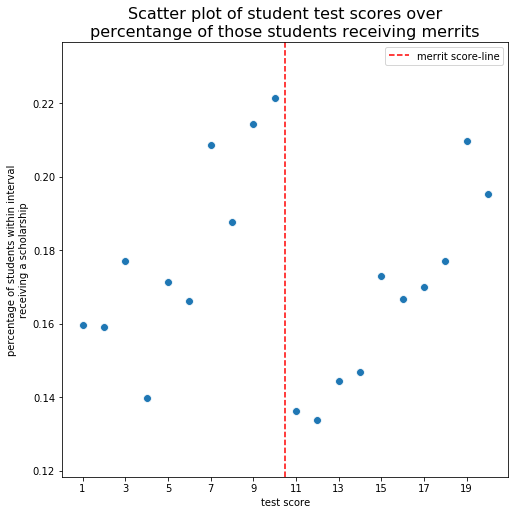

In [38]:
# VISUALIZATION
# create plot objects
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)

# plot data
_ = sns.scatterplot(x=predictor, 
                    y=target,
                    data=data,
                    s=62,
                    ax=ax)
_ = ax.axvline(threshold, color='r', linestyle='dashed', label='merrit score-line')  # threshold line

# label plot
_ = ax.set_xlabel('test score')
_ = ax.set_ylabel('percentage of students within interval\nreceiving a scholarship')
_ = ax.set_title('Scatter plot of student test scores over\npercentange of those students receiving merrits', fontsize=16)
_ = ax.legend()

# pretify plot
_ = ax.grid(False)
_ = ax.set_xticks(data[predictor][::2])
_ = ax.set_xticklabels(data[predictor][::2])

# show plot
plt.show()

The illustration might allow to hypothesize about some linear relation between, e.g. between the theta frequency band data, but certainly not about any thresholds.

### Basic linear regression
As reference we fit a simple linear regression of our predictor *test_score* on the target *rel_num_students_w_scholarship*.

In [39]:
# Create linear regression model
regr = {}

X = data[predictor]
X = sm.add_constant(X)  # add column of 1s for slope interception
y = data[target]
regression_model = sm.OLS(y, X, missing='drop').fit()

print(regression_model.summary())

                                  OLS Regression Results                                  
Dep. Variable:     rel_num_students_w_scholarship   R-squared:                       0.026
Model:                                        OLS   Adj. R-squared:                 -0.028
Method:                             Least Squares   F-statistic:                    0.4822
Date:                            Tue, 05 Nov 2019   Prob (F-statistic):              0.496
Time:                                    10:58:39   Log-Likelihood:                 44.965
No. Observations:                              20   AIC:                            -85.93
Df Residuals:                                  18   BIC:                            -83.94
Df Model:                                       1                                         
Covariance Type:                        nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------

*Evaluation*

### Regression Discontiuity Analysis

In [40]:
# bandwidth_opt = rdd.optimal_bandwidth(data[predictor], data[target], cut=threshold)

In [41]:
# truncate data
# data_rdd = rdd.truncated_data(data, 
#                               xname=predictor, 
#                               bandwidth=bandwidth_opt, 
#                               yname=target,
#                               cut=threshold)
data_rdd = data

We perform RDD analysis using the rdd toolbox. The return is an ordinary least squares fit to a linear model. However, more general models can be passed to the function. For details check [rdd tutorial in github](https://github.com/evan-magnusson/rdd/blob/master/tutorial/tutorial.ipynb) and the [statsmodels documentary](https://www.statsmodels.org/dev/generated/statsmodels.regression.linear_model.OLS.html).

In [42]:
# perform rdd analysis
rdd_model = rdd.rdd(data_rdd, xname=predictor, yname=target, cut=threshold)
rdd_model = rdd_model.fit()

# print results
print(rdd_model.summary())

Estimation Equation:	 rel_num_students_w_scholarship ~ TREATED + test_score
                                  WLS Regression Results                                  
Dep. Variable:     rel_num_students_w_scholarship   R-squared:                       0.786
Model:                                        WLS   Adj. R-squared:                  0.761
Method:                             Least Squares   F-statistic:                     31.18
Date:                            Tue, 05 Nov 2019   Prob (F-statistic):           2.05e-06
Time:                                    10:58:39   Log-Likelihood:                 60.108
No. Observations:                              20   AIC:                            -114.2
Df Residuals:                                  17   BIC:                            -111.2
Df Model:                                       2                                         
Covariance Type:                        nonrobust                                         
              

*evaluation*

Let's add the *TREATED* variable to our data.
(Conversion of dtype from boolean to int is necessary for compatibility with `sm.OLS` model.

In [43]:
data['TREATED'] = (~data['merit_scholars'].isna()).astype(int)
print('Head')
data.head(3)
print('Tail')
data.tail(3)

Head


/Users/akshay/anaconda3/envs/causality/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,certificate_of_merit,test_score,merit_scholars,number_in_sample,number_respondents,scholarship,scholarship_150,graduate_study,teacher_researcher,intellectualism,rel_num_students_w_scholarship,TREATED
1,0,1,NaN,318,256,50.8,41.6,30.6,22.0,3.8,0.159748,0
2,0,2,NaN,368,281,58.6,47.0,26.1,18.2,3.6,0.159239,0
3,0,3,NaN,320,258,56.7,46.3,29.2,23.8,3.7,0.177187,0


Tail


,certificate_of_merit,test_score,merit_scholars,number_in_sample,number_respondents,scholarship,scholarship_150,graduate_study,teacher_researcher,intellectualism,rel_num_students_w_scholarship,TREATED
18,1,18,18.0,345,256,61.1,52.8,36.4,24.9,4.0,0.177101,1
19,1,19,17.0,254,211,53.3,48.0,44.7,28.8,4.1,0.209843,1
20,1,20,23.0,301,237,58.8,52.8,40.3,28.0,4.1,0.195349,1


Let's predict our model and store the results in our original dataframe.

In [44]:
prediction = 'scholarship_prediction'
data[prediction] = rdd_model.predict(data)
# data

/Users/akshay/anaconda3/envs/causality/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Let's visualize our results.

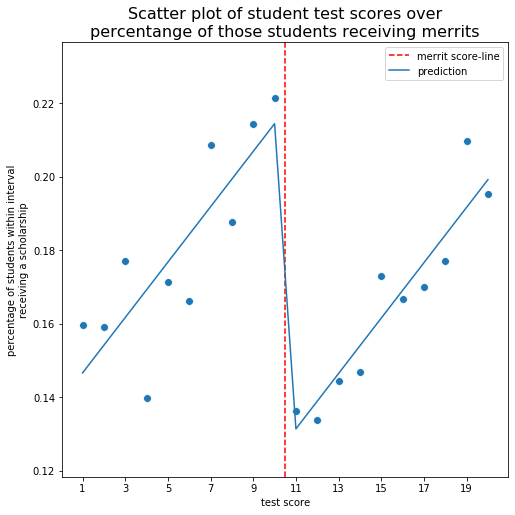

In [45]:
# VISUALIZATION
# create plot objects
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)

# plot data
_ = sns.scatterplot(x=predictor, 
                    y=target,
                    data=data,
                    s=62,
                    ax=ax)
_ = ax.axvline(threshold, color='r', linestyle='dashed', label='merrit score-line')  # threshold line
_ = sns.lineplot(x=predictor, y=prediction, data=data, label='prediction')

# label plot
_ = ax.set_xlabel('test score')
_ = ax.set_ylabel('percentage of students within interval\nreceiving a scholarship')
_ = ax.set_title('Scatter plot of student test scores over\npercentange of those students receiving merrits', fontsize=16)
_ = ax.legend()

# pretify plot
_ = ax.grid(False)
_ = ax.set_xticks(data[predictor][::2])
_ = ax.set_xticklabels(data[predictor][::2])

# show plot
plt.show()